## Using RNN(LSTM) with PyTorch

We can also predict sentiment using RNN which works best for sequential data such as text.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from tqdm  import tqdm

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
X = df['review']
y = df['sentiment']

y = (y.replace({'positive': 1, 'negative': 0})).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Tokenization

import torchtext <br>
from torchtext.data import get_tokenizer<br>
tokenizer = get_tokenizer("basic_english")<br>
tokens = tokenizer("You can now install TorchText using pip!")<br>
tokens<br>

Output: ['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']

In [ ]:
# Tokenize the text data
tokenizer = get_tokenizer('basic_english')
train_tokens = [tokenizer(text) for text in X_train]
test_tokens = [tokenizer(text) for text in X_test]

from torchtext.vocab import build_vocab_from_iterator<br>
vocab = build_vocab_from_iterator(yield_tokens(file_path), specials=["< unk >"])

In [ ]:
# Build vocabulary from the training data
vocab = build_vocab_from_iterator(train_tokens, specials=["<unk>"])

In [ ]:
vocab = vocab.get_stoi()

In [ ]:
V = len(vocab)
V

130582

In [ ]:
# Numericalize the tokens
train_numericalized = [torch.tensor([vocab.get(token, 0) for token in tokens]) for tokens in train_tokens]
test_numericalized = [torch.tensor([vocab.get(token, 0) for token in tokens]) for tokens in test_tokens]

### Padding

`pad_sequence` in PyTorch is a utility function used to pad sequences to the same length within a batch. This is often required when dealing with sequences of varying lengths, such as sentences in natural language processing tasks.

In [ ]:
train_len = [len(x) for x in train_numericalized]
test_len = [len(x) for x in test_numericalized]

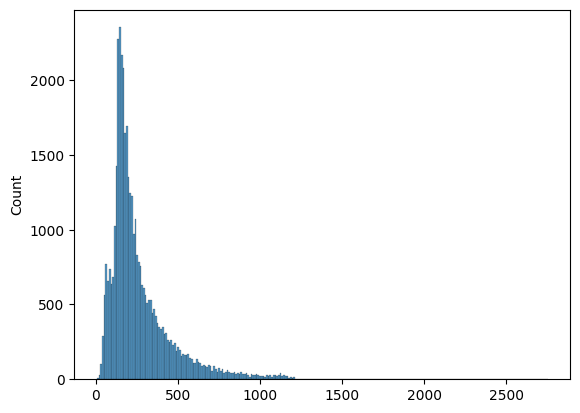

In [ ]:
sns.histplot(train_len);

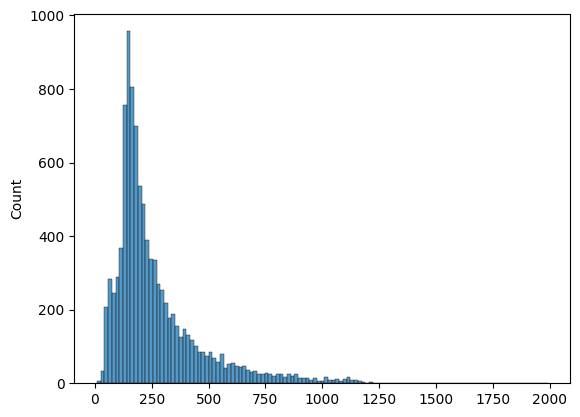

In [ ]:
sns.histplot(test_len);

In [ ]:
T = 1250 # max_size (from histplot)

In [ ]:
# Reverse the sequences
reversed_seqs_train = [seq.flip(0) for seq in train_numericalized]

# Pad sequences to have the same length
reversed_padded_train = pad_sequence(reversed_seqs_train, batch_first=True)[:, :T]

# Reverse the padded sequences back
X_train_padded = reversed_padded_train.flip(1)

In [ ]:
reversed_seqs_test = [seq.flip(0) for seq in test_numericalized]

reversed_padded = pad_sequence(test_numericalized, batch_first=True)[:, :T]

X_test_padded = reversed_padded.flip(1)

### Batching the dataset

In [ ]:
# Create tensor dataset
training_data = TensorDataset(X_train_padded,torch.from_numpy(y_train))
testing_data = TensorDataset(X_test_padded,torch.from_numpy(y_test))

# Dataloader
batch_size=32
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(testing_data, batch_size=batch_size, drop_last=True)

In [ ]:
# One batch of training data
dataiter = iter(train_loader)
sample_x, sample_y =next(dataiter)

sample_x, sample_y

(tensor([[    0,     0,     0,  ...,   439,  1069,     2],
         [    0,     0,     0,  ...,     2,   762,     2],
         [    0,     0,     0,  ...,   204,   410,     2],
         ...,
         [    0,     0,     0,  ..., 12604,   519,     2],
         [    0,     0,     0,  ...,    13,  6742,    35],
         [    0,     0,     0,  ...,     2,  2003, 50500]]),
 tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
         0, 0, 1, 0, 0, 1, 0, 1]))

### Building Model

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, num_layers, vocab_size, hidden_dim, embedding_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=self.hidden_dim,
                           num_layers=num_layers,
                           batch_first=True)
        # dropout layer
        self.dropout = nn.Dropout(0.3)
         # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)

        hidden = (h0, c0)
        return hidden

In [ ]:
num_layers = 2
vocab_size = V + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentLSTM(num_layers,vocab_size,hidden_dim,embedding_dim, output_dim)


#moving to gpu
model.to(device)

print(model)

SentimentLSTM(
  (embedding): Embedding(130583, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred==label.squeeze()).item()

In [ ]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_tst_loss = [],[]
epoch_tr_acc,epoch_tst_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0

    model.train()

    # initialize hidden state
    h = model.init_hidden(batch_size)

    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()

        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())

        loss.backward()
        train_losses.append(loss.item())

        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    test_h = model.init_hidden(batch_size)
    test_losses = []
    test_acc = 0.0

    model.eval()

    for inputs, labels in test_loader:
        test_h = tuple([each.data for each in test_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, test_h = model(inputs, test_h)
        test_loss = criterion(output.squeeze(), labels.float())

        test_losses.append(test_loss.item())

        accuracy = acc(output,labels)
        test_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_test_loss = np.mean(test_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_test_acc = test_acc/len(test_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_tst_loss.append(epoch_test_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_tst_acc.append(epoch_test_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_test_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_test_acc*100}')
    if epoch_test_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_test_loss))
        valid_loss_min = epoch_test_loss
    print(25*'==')

Epoch 1
train_loss : 0.6218993670463562 val_loss : 0.5680224000452421
train_accuracy : 63.6825 val_accuracy : 70.58
Validation loss decreased (inf --> 0.568022).  Saving model ...
Epoch 2
train_loss : 0.3434756384909153 val_loss : 0.421793333421915
train_accuracy : 85.4725 val_accuracy : 80.84
Validation loss decreased (0.568022 --> 0.421793).  Saving model ...
Epoch 3
train_loss : 0.22837009001225234 val_loss : 0.353297169917287
train_accuracy : 91.07 val_accuracy : 84.25
Validation loss decreased (0.421793 --> 0.353297).  Saving model ...
Epoch 4
train_loss : 0.1686401544511318 val_loss : 0.42148390414718634
train_accuracy : 93.76 val_accuracy : 83.78
Epoch 5
train_loss : 0.12136619133204221 val_loss : 0.3864806940038808
train_accuracy : 95.83 val_accuracy : 85.81


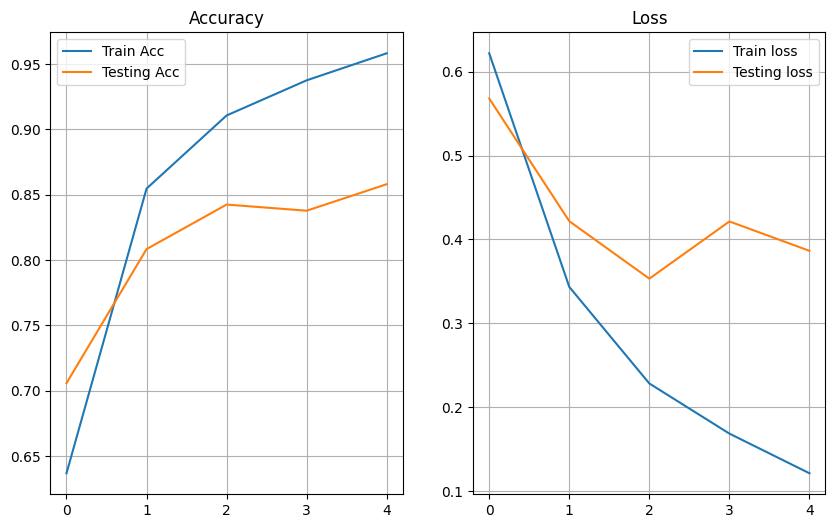

In [ ]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_tst_acc, label='Testing Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_tst_loss, label='Testing loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()